## Name: Luke Pratley
## Date Week 6

## EDA and Mask generation for Las Vegas Building Footprint detection

In [2]:
%matplotlib inline
import sys, os
sys.path.insert(0,os.path.abspath('../../building_road_segmentation'))

import building_road_segmentation

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import glob
import os

import shapely.wkt
import geopandas as gpd
import rasterio
import rasterio.features
from rasterio.merge import merge
from rasterio.plot import show
from shapely.geometry import box

In [136]:
data_directory = 'D:\Capstone Project\data\\'
datasets = glob.glob(data_directory + '*')
datasets = [d.split('\\')[-1] for d in datasets]
dataset_index = 7
datasets

['AOI_2_Vegas',
 'AOI_2_Vegas_Train',
 'AOI_3_Paris',
 'AOI_3_Paris_Train',
 'AOI_4_Shanghai',
 'AOI_4_Shanghai_Train',
 'AOI_5_Khartoum',
 'AOI_5_Khartoum_Train',
 'final_images',
 'final_masks',
 'SN2_buildings_train_AOI_2_Vegas.tar.gz',
 'SN2_buildings_train_AOI_3_Paris.tar.gz',
 'SN2_buildings_train_AOI_4_Shanghai.tar.gz',
 'SN2_buildings_train_AOI_5_Khartoum.tar.gz',
 'SN3_roads_train_AOI_2_Vegas.tar.gz',
 'SN3_roads_train_AOI_3_Paris.tar.gz',
 'SN3_roads_train_AOI_4_Shanghai.tar.gz',
 'SN3_roads_train_AOI_5_Khartoum.tar.gz']

Below we are creating a dictionary that makes it easier to keep track of the image directories.

In [137]:
directories_dict = building_road_segmentation.get_directories_dictionary(data_directory, dataset_index)
directories_dict

{'MUL': 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\MUL',
 'MUL-PanSharpen': 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\MUL-PanSharpen',
 'PAN': 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\PAN',
 'RGB-PanSharpen': 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\RGB-PanSharpen',
 'building_mask': 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\building_mask',
 'geojson': 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\geojson',
 'road_mask': 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\road_mask'}

Below I am listing the directories in the dataset. 

In [138]:
directories = glob.glob(data_directory + f'{datasets[dataset_index]}\*')
directories.sort()

directories

['D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\MUL',
 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\MUL-PanSharpen',
 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\PAN',
 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\RGB-PanSharpen',
 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\building_mask',
 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\geojson',
 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\road_mask',
 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\summaryData']

## Data Cleaning

Here we are reading in information about the labels; the table containing the building locations:

In [139]:
building_info_df = gpd.read_file(glob.glob(directories[-1]+'\*')[0])

In [140]:
building_info_df.head(10)

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo,geometry
0,AOI_5_Khartoum_img1240,1,"POLYGON ((508.93 461.14 0,510.93 460.63 0,512....",POLYGON ((32.559167521982651 15.63541610998623...,None
1,AOI_5_Khartoum_img1240,2,"POLYGON ((650.0 566.61 0,650.0 430.92 0,616.37...",POLYGON ((32.559548400025243 15.63513134788442...,None
2,AOI_5_Khartoum_img1240,3,"POLYGON ((291.55 430.09 0,290.14 415.95 0,274....",POLYGON ((32.558580596912037 15.63549995555238...,None
3,AOI_5_Khartoum_img1240,4,"POLYGON ((432.58 464.83 0,484.8 461.22 0,481.2...",POLYGON ((32.55896136042162 15.635406169418781...,None
4,AOI_5_Khartoum_img1240,5,"POLYGON ((581.21 408.69 0,525.15 405.15 0,522....",POLYGON ((32.559362671096714 15.63555774853030...,None
5,AOI_5_Khartoum_img1240,6,"POLYGON ((650.0 423.21 0,650.0 405.46 0,615.52...",POLYGON ((32.559548400025243 15.63551852942922...,None
6,AOI_5_Khartoum_img1240,7,"POLYGON ((292.37 638.49 0,214.82 639.9 0,215 6...",POLYGON ((32.558582802276078 15.63493726492348...,None
7,AOI_5_Khartoum_img1240,8,"POLYGON ((245.77 626.48 0,245.13 606.77 0,212....",POLYGON ((32.558456979745792 15.63496971133350...,None
8,AOI_5_Khartoum_img1240,9,"POLYGON ((523.46 595.98 0,493.04 595.71 0,492....",POLYGON ((32.559206747817882 15.63505205444595...,None
9,AOI_5_Khartoum_img1240,10,"POLYGON ((544.14 623.69 0,543.68 612.26 0,593....",POLYGON ((32.559262574519529 15.63497722451883...,None


In [141]:
building_info_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 25551 entries, 0 to 25550
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ImageId         25551 non-null  object  
 1   BuildingId      25551 non-null  object  
 2   PolygonWKT_Pix  25551 non-null  object  
 3   PolygonWKT_Geo  25551 non-null  object  
 4   geometry        0 non-null      geometry
dtypes: geometry(1), object(4)
memory usage: 998.2+ KB


We are changing the building ID to an integer then check if there are any negative values:

In [142]:
building_info_df['BuildingId'] = building_info_df['BuildingId'].astype(int)

In [143]:
building_info_df[building_info_df['BuildingId'] < 1]

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo,geometry
32,AOI_5_Khartoum_img1227,-1,POLYGON EMPTY,POLYGON EMPTY,None
223,AOI_5_Khartoum_img675,-1,POLYGON EMPTY,POLYGON EMPTY,None
1272,AOI_5_Khartoum_img259,-1,POLYGON EMPTY,POLYGON EMPTY,None
1430,AOI_5_Khartoum_img314,-1,POLYGON EMPTY,POLYGON EMPTY,None
1431,AOI_5_Khartoum_img454,-1,POLYGON EMPTY,POLYGON EMPTY,None
...,...,...,...,...,...
23207,AOI_5_Khartoum_img264,-1,POLYGON EMPTY,POLYGON EMPTY,None
23623,AOI_5_Khartoum_img1686,-1,POLYGON EMPTY,POLYGON EMPTY,None
23858,AOI_5_Khartoum_img758,-1,POLYGON EMPTY,POLYGON EMPTY,None
24232,AOI_5_Khartoum_img797,-1,POLYGON EMPTY,POLYGON EMPTY,None


We will now see if we should remove all of these rows by checking if they are all empty polygons.

In [144]:
building_info_df[building_info_df['BuildingId'] < 1]['PolygonWKT_Pix'].value_counts()

POLYGON EMPTY    88
Name: PolygonWKT_Pix, dtype: int64

In [145]:
building_info_df[building_info_df['BuildingId'] < 1]['PolygonWKT_Geo'].value_counts()

POLYGON EMPTY    88
Name: PolygonWKT_Geo, dtype: int64

They are all empty and we will drop these rows

In [146]:
building_info_df = building_info_df[building_info_df['BuildingId'] > 0]

We will now check if there are any other empty polygons.

In [147]:
building_info_df[building_info_df['PolygonWKT_Pix'] == 'POLYGON EMPTY']

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo,geometry


In [148]:
building_info_df[building_info_df['PolygonWKT_Geo'] == 'POLYGON EMPTY']

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo,geometry


We drop the rows with empty polygons because it is likely they are not actually in the image. Also it is just more than a handful of rows... It is not a big loss! Maybe we can consider using the geospatial coordinates to repear these values.

In [149]:
building_info_df = building_info_df[building_info_df['PolygonWKT_Pix'] != 'POLYGON EMPTY']

Now we are going to check for null values:

In [150]:
building_info_df.isna().sum()

ImageId               0
BuildingId            0
PolygonWKT_Pix        0
PolygonWKT_Geo        0
geometry          25463
dtype: int64

There are no null values except for geometry.

In [151]:
pd.DataFrame(building_info_df['geometry']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25463 entries, 0 to 25550
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  0 non-null      geometry
dtypes: geometry(1)
memory usage: 397.9 KB


All of the values are null. I am not sure what the column is for, but I am thinking I will drop it for now since I am not sure why it is useful as it is.

In [152]:
building_info_df.drop(columns=['geometry'], axis=1, inplace=True)

In [153]:
building_info_df.head(10)

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo
0,AOI_5_Khartoum_img1240,1,"POLYGON ((508.93 461.14 0,510.93 460.63 0,512....",POLYGON ((32.559167521982651 15.63541610998623...
1,AOI_5_Khartoum_img1240,2,"POLYGON ((650.0 566.61 0,650.0 430.92 0,616.37...",POLYGON ((32.559548400025243 15.63513134788442...
2,AOI_5_Khartoum_img1240,3,"POLYGON ((291.55 430.09 0,290.14 415.95 0,274....",POLYGON ((32.558580596912037 15.63549995555238...
3,AOI_5_Khartoum_img1240,4,"POLYGON ((432.58 464.83 0,484.8 461.22 0,481.2...",POLYGON ((32.55896136042162 15.635406169418781...
4,AOI_5_Khartoum_img1240,5,"POLYGON ((581.21 408.69 0,525.15 405.15 0,522....",POLYGON ((32.559362671096714 15.63555774853030...
5,AOI_5_Khartoum_img1240,6,"POLYGON ((650.0 423.21 0,650.0 405.46 0,615.52...",POLYGON ((32.559548400025243 15.63551852942922...
6,AOI_5_Khartoum_img1240,7,"POLYGON ((292.37 638.49 0,214.82 639.9 0,215 6...",POLYGON ((32.558582802276078 15.63493726492348...
7,AOI_5_Khartoum_img1240,8,"POLYGON ((245.77 626.48 0,245.13 606.77 0,212....",POLYGON ((32.558456979745792 15.63496971133350...
8,AOI_5_Khartoum_img1240,9,"POLYGON ((523.46 595.98 0,493.04 595.71 0,492....",POLYGON ((32.559206747817882 15.63505205444595...
9,AOI_5_Khartoum_img1240,10,"POLYGON ((544.14 623.69 0,543.68 612.26 0,593....",POLYGON ((32.559262574519529 15.63497722451883...


In [154]:
building_info_df.head()

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo
0,AOI_5_Khartoum_img1240,1,"POLYGON ((508.93 461.14 0,510.93 460.63 0,512....",POLYGON ((32.559167521982651 15.63541610998623...
1,AOI_5_Khartoum_img1240,2,"POLYGON ((650.0 566.61 0,650.0 430.92 0,616.37...",POLYGON ((32.559548400025243 15.63513134788442...
2,AOI_5_Khartoum_img1240,3,"POLYGON ((291.55 430.09 0,290.14 415.95 0,274....",POLYGON ((32.558580596912037 15.63549995555238...
3,AOI_5_Khartoum_img1240,4,"POLYGON ((432.58 464.83 0,484.8 461.22 0,481.2...",POLYGON ((32.55896136042162 15.635406169418781...
4,AOI_5_Khartoum_img1240,5,"POLYGON ((581.21 408.69 0,525.15 405.15 0,522....",POLYGON ((32.559362671096714 15.63555774853030...


We check for duplicates. It is clear that the columns PolygonWKT_Pix and PolygonWKT_Geo hold the same information, but one is in pixel coordinates and the other is in geospatial coordinates. Both of these are useful depending on how the coordinate system, it is much easier to keep both than convert between coordinates manually for now.

In [155]:
building_info_df[building_info_df.duplicated()]

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo


In [156]:
building_info_df["PolygonWKT_Geo"] = building_info_df["PolygonWKT_Geo"].apply(lambda x: shapely.wkt.loads(x))

Lastly, we are going to drop the pixel coordinates in favour of the geospatial coordinates:

In [157]:
building_info_df.drop(columns=['PolygonWKT_Pix'], axis=1, inplace=True)

In [158]:
building_info_df.rename(columns={'PolygonWKT_Geo' :'geometry'}, inplace=True)

In [159]:
building_info_df

,ImageId,BuildingId,geometry
0,AOI_5_Khartoum_img1240,1,"POLYGON Z ((32.55917 15.63542 0.00000, 32.5591..."
1,AOI_5_Khartoum_img1240,2,"POLYGON Z ((32.55955 15.63513 0.00000, 32.5594..."
2,AOI_5_Khartoum_img1240,3,"POLYGON Z ((32.55858 15.63550 0.00000, 32.5585..."
3,AOI_5_Khartoum_img1240,4,"POLYGON Z ((32.55896 15.63541 0.00000, 32.5586..."
4,AOI_5_Khartoum_img1240,5,"POLYGON Z ((32.55936 15.63556 0.00000, 32.5593..."
...,...,...,...
25546,AOI_5_Khartoum_img947,1,"POLYGON Z ((32.55428 15.70349 0.00000, 32.5542..."
25547,AOI_5_Khartoum_img459,1,"POLYGON Z ((32.54189 15.69635 0.00000, 32.5419..."
25548,AOI_5_Khartoum_img459,2,"POLYGON Z ((32.54199 15.69633 0.00000, 32.5420..."
25549,AOI_5_Khartoum_img459,3,"POLYGON Z ((32.54186 15.69636 0.00000, 32.5418..."


We can see that there are no duplicate rows from the above cell.

We are now going to check for duplicate building Ids:

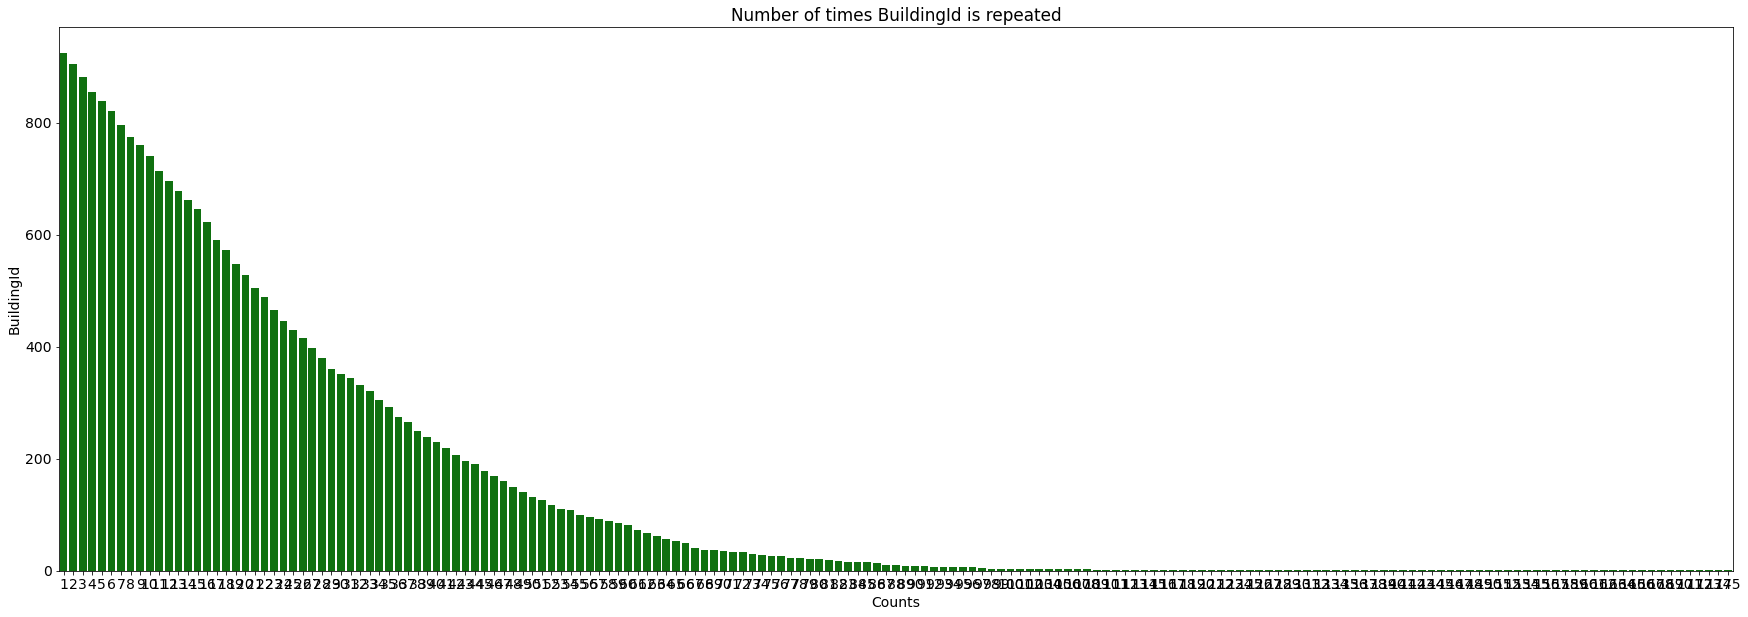

In [160]:
plt.figure(figsize=(30, 10))
plt.title('Number of times BuildingId is repeated')
sns.barplot(data=pd.DataFrame(building_info_df['BuildingId']).value_counts().reset_index(), x='BuildingId', y=0, color = 'green')
plt.ylabel('BuildingId')
plt.xlabel('Counts')
plt.show()

It turns out that we expect the duplicate BuildingIds, because the Id is image specific. This means two buildings with the same Id are typically different if they are in different images.

Now we want to save this dataframe because we will need it when cross matching buildings in the roads dataset.

In [161]:
image_names = np.array(building_info_df['ImageId'].unique().astype(str))
image_names.sort()
print(f'We expect to have this many images (of a given type): {image_names.shape[0]}')

We expect to have this many images (of a given type): 924


Lastly, we are going to check that a BuildingId does not appear twice within the same image.

In [124]:
for im in image_names:
    if building_info_df[building_info_df['ImageId'] == im]['BuildingId'].duplicated().sum() > 0:
        print(f'{im} has at least one duplicate BuildingId. You need to investigate!')

We are now going to save the table into cleaned geojson files

In [162]:
directories_dict

{'MUL': 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\MUL',
 'MUL-PanSharpen': 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\MUL-PanSharpen',
 'PAN': 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\PAN',
 'RGB-PanSharpen': 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\RGB-PanSharpen',
 'building_mask': 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\building_mask',
 'geojson': 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\geojson',
 'road_mask': 'D:\\Capstone Project\\data\\AOI_5_Khartoum_Train\\road_mask'}

Now we are going to investigate the image directories. We can check that all of the files we expect exist from the `image_names` list that we created.

In [163]:
for im in image_names:
    file_path = f'{directories_dict["geojson"]}\\buildings\\buildings_{im}.geojson'
    building_info_df[building_info_df['ImageId'] == im].to_file(file_path, driver='GeoJSON')

We are using a custom function that takes this dictionary and creates a path from a given folder name and image name.

Below we are checking that none of the image files are missing given that we know the image for each of the buildings that we have:

In [31]:
for im in image_names:
    for key, item in directories_dict.items():
        if key != 'geojson' and key !='building_mask' and key !='road_mask':
            file_path = building_road_segmentation.get_image_path(directories_dict, key, im)
            if not os.path.exists(file_path):
                print(f'{file_path} does not exist')
        elif key == 'geojson':
            file_path = f'{directories_dict["geojson"]}\\buildings\\buildings_{im}.geojson'
            if not os.path.exists(file_path):
                print(f'{file_path} does not exist')

We can check what the type and shape is for each image:

In [32]:
shape_dictionary = dict()
for key, item in directories_dict.items():
    if key != 'geojson' and key !='building_mask' and key !='road_mask':
        with rasterio.open(building_road_segmentation.get_image_path(directories_dict, key, image_names[0])) as image:
            shape_dictionary[key] = image.read().shape
            print(type(image))
            print(type(image.read()))
shape_dictionary

<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>
<class 'rasterio.io.DatasetReader'>
<class 'numpy.ndarray'>


{'MUL': (8, 163, 163),
 'MUL-PanSharpen': (8, 650, 650),
 'PAN': (1, 650, 650),
 'RGB-PanSharpen': (3, 650, 650)}

From the website, we expect our observations to be of the form:

MS             > Raw source geotiffs of 8-Band Multi-Spectral raster data from WorldView-3

PS-MS          > Raw source geotiffs and COGs of 8-Band Multi-Spectral raster data pansharpened to 0.3m

PAN            > Raw source geotiffs of Panchromatic raster data from Worldview-3

PS-RGB         > Raw source geotiffs of RGB raster data from Worldview-3 pansharpened to 0.3m



In [88]:
print(directories_dict)

{'MUL': 'D:\\Capstone Project\\data\\AOI_3_Paris_Train\\MUL', 'MUL-PanSharpen': 'D:\\Capstone Project\\data\\AOI_3_Paris_Train\\MUL-PanSharpen', 'PAN': 'D:\\Capstone Project\\data\\AOI_3_Paris_Train\\PAN', 'RGB-PanSharpen': 'D:\\Capstone Project\\data\\AOI_3_Paris_Train\\RGB-PanSharpen', 'building_mask': 'D:\\Capstone Project\\data\\AOI_3_Paris_Train\\building_mask', 'geojson': 'D:\\Capstone Project\\data\\AOI_3_Paris_Train\\geojson', 'road_mask': 'D:\\Capstone Project\\data\\AOI_3_Paris_Train\\road_mask'}


In [89]:
#for im in image_names:
#    for key, item in directories_dict.items():
        #with rasterio.open(get_image_path(key, im)) as image:
        #    if shape_dictionary[key] != image.shape:
        #        print(f'{item} has a different image size from what was expected.')

Now we take a look at what an image looks like for each folder:

AOI_5_Khartoum_img1003


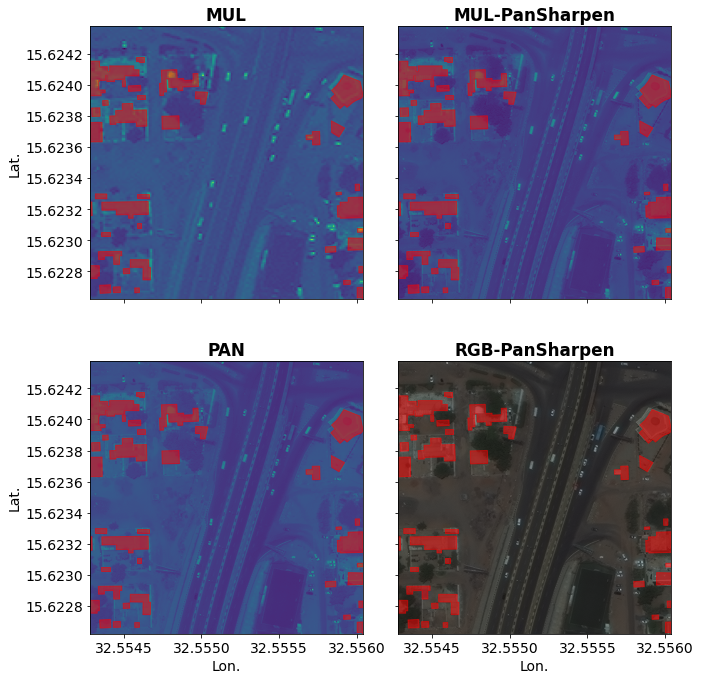

In [164]:
print(image_names[4])
building_road_segmentation.plot_images(directories_dict, image_names[4])

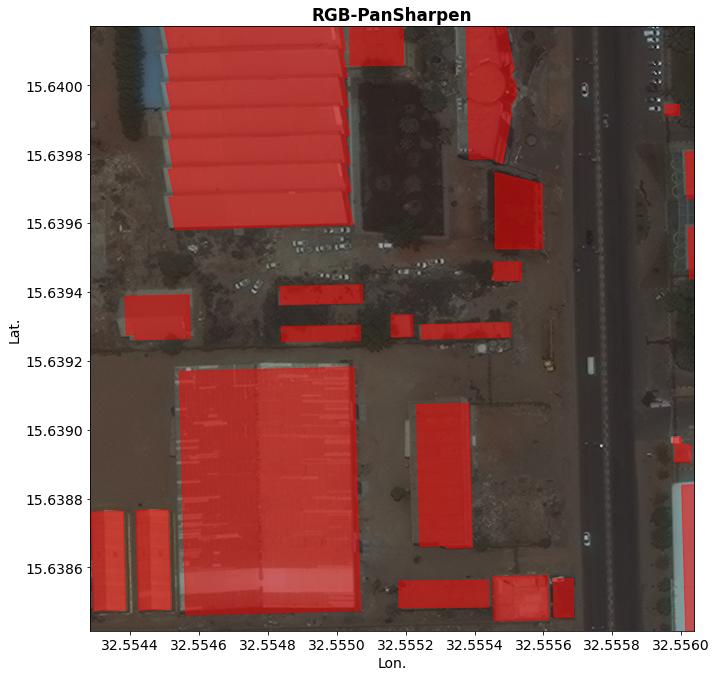

In [165]:
building_road_segmentation.plot_image(directories_dict, image_names[10])

The above plot was mading using the geopandas dictionary:

In [ ]:
building_road_segmentation.get_geopandas_for_image(directories_dict, image_names[5])

We need a function to create images for the masks that the ML method will predict. We need to create our polygon objects and check what pixels lie within them. Below we use functionality from rasterio to do this with the geometry object from geopandas:

In [ ]:
plt.imshow(building_road_segmentation.create_mask(directories_dict, image_names[10]))

In [ ]:
image_names[10]

In [ ]:
#np.save(datasets[dataset_index] + '_image_names', image_names)

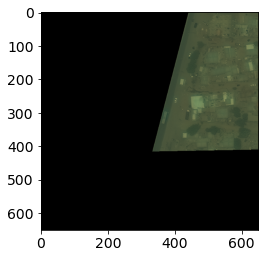

AOI_5_Khartoum_img1


In [166]:
count  = 0
for k, im in enumerate(image_names):
    path = f'D:\\Capstone Project\\data\\final_images\\{im}.npy'
    with rasterio.open(building_road_segmentation.get_image_path(directories_dict, 'RGB-PanSharpen', im)) as image:
        np.save(path, np.moveaxis(image.read(), 0, 2))
        if count % 1000 == 0:
            plt.imshow(np.moveaxis(image.read(), 0, 2)/1800)
            plt.show()
            print(im)
    count += 1

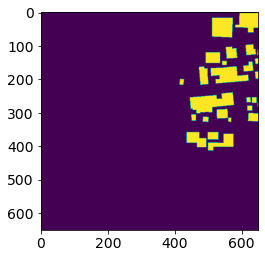

D:\Capstone Project\data\final_masks\building_mask_AOI_5_Khartoum_img1.npy


In [167]:
count  = 0
for k, im in enumerate(image_names):
    path = f'D:\\Capstone Project\\data\\final_masks\\building_mask_{im}.npy'
    mask = building_road_segmentation.create_mask(directories_dict, im)
    np.save(path, mask)
    if count % 1000 == 0:
        plt.imshow(mask)
        plt.show()
        print(path)
    count += 1

In [168]:
roads_geojson_files = [gpd.read_file(d) for d in glob.glob(data_directory + datasets[7] + '\\summaryData\\roads.geojson')]


In [169]:
roads_df = pd.concat(roads_geojson_files, axis=0, ignore_index=True)
roads_df.shape

(10103, 13)

In [170]:
roads_df.head()

,bridge_type,heading,lane_numbe,lane_number,one_way_type,paved,road_id,road_type,origarea,origlen,partialDec,truncated,geometry
0,2,0,2,2,2,1,8013,2,0,0.000771,1,0,"LINESTRING (32.48751 15.51732, 32.48744 15.51703)"
1,2,0,2,2,2,2,10836,5,0,0.000423,1,0,"LINESTRING (32.48901 15.51732, 32.48901 15.51732)"
2,2,0,2,2,2,2,11989,5,0,0.000362,1,0,"LINESTRING (32.48821 15.51625, 32.48815 15.51661)"
3,2,0,2,2,2,2,6562,5,0,0.000837,1,0,"LINESTRING (32.48815 15.51661, 32.48784 15.516..."
4,2,0,2,2,2,2,6731,5,0,0.000436,1,0,"LINESTRING (32.48901 15.51683, 32.48898 15.51640)"


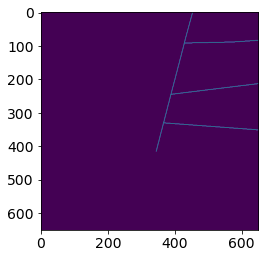

D:\Capstone Project\data\final_masks\road_mask_AOI_5_Khartoum_img1.npy


In [171]:
count = 0
image_dirs = glob.glob(directories_dict['RGB-PanSharpen'] + '\\*')
image_dirs.sort()
for image_name in image_names:
    with rasterio.open(building_road_segmentation.get_image_path(directories_dict, 'RGB-PanSharpen', image_name)) as image:
        path = f'D:\\Capstone Project\\data\\final_masks\\road_mask_{image_name}.npy'
        bounds = box(*image.bounds)
        check_bounds =  np.vectorize(lambda x : bounds.intersects(x))
        road_overlap = check_bounds(roads_df['geometry'])
        img = image.read()
        img = np.moveaxis(img, 0, 2)
        if road_overlap.sum() > 0:
            road_mask = rasterio.features.geometry_mask(roads_df['geometry'][road_overlap], image.shape, image.transform, all_touched=False, invert=True)
        else:
            road_mask = -1 * np.ones((img.shape[0], img.shape[1]))
        np.save(path, road_mask)
        if count % 1000 == 0:
            plt.imshow(road_mask)
            plt.show()
            print(path)
        count += 1
        